# Spatial joins

Goals of this notebook:

- Based on the `countries` and `cities` dataframes, determine for each city the country in which it is located.
- To solve this problem, we will use the the concept of a 'spatial join' operation: combining information of geospatial datasets based on their spatial relationship.

In [ ]:
!pip install geopandas

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import modulo os e installazione di rtree e altro per far funzionare l'sjoin
import os
!pip install rtree
!curl -L http://download.osgeo.org/libspatialindex/spatialindex-src-1.8.5.tar.gz | tar xz
os.chdir("/content/spatialindex-src-1.8.5")
!./configure
!make
!make install
!ldconfig


In [ ]:
%matplotlib inline
import pandas as pd
import geopandas
import matplotlib.pyplot as plt

In [ ]:
countries = geopandas.read_file("/content/drive/MyDrive/Colab Notebooks/4E INF/GEOpands/geopandas-tutorial-master/geopandas-tutorial-master/data/ne_110m_admin_0_countries.zip")
cities = geopandas.read_file("/content/drive/MyDrive/Colab Notebooks/4E INF/GEOpands/geopandas-tutorial-master/geopandas-tutorial-master/data/ne_110m_populated_places.zip")
rivers = geopandas.read_file("/content/drive/MyDrive/Colab Notebooks/4E INF/GEOpands/geopandas-tutorial-master/geopandas-tutorial-master/data/ne_50m_rivers_lake_centerlines.zip")

## Recap - joining dataframes

Pandas provides functionality to join or merge dataframes in different ways, see https://chrisalbon.com/python/data_wrangling/pandas_join_merge_dataframe/ for an overview and https://pandas.pydata.org/pandas-docs/stable/merging.html for the full documentation.

To illustrate the concept of joining the information of two dataframes with pandas, let's take a small subset of our `cities` and `countries` datasets: 

In [ ]:
cities2 = cities[cities['name'].isin(['Bern', 'Brussels', 'London', 'Paris'])].copy()
cities2['iso_a3'] = ['CHE', 'BEL', 'GBR', 'FRA']

In [ ]:
cities2

,name,geometry,iso_a3
26,Bern,POINT (7.46698 46.91668),CHE
170,Brussels,POINT (4.33137 50.83526),BEL
219,London,POINT (-0.11867 51.50194),GBR
235,Paris,POINT (2.33139 48.86864),FRA


In [ ]:
countries2 = countries[['iso_a3', 'name', 'continent']]
countries2.head()

,iso_a3,name,continent
0,AFG,Afghanistan,Asia
1,AGO,Angola,Africa
2,ALB,Albania,Europe
3,ARE,United Arab Emirates,Asia
4,ARG,Argentina,South America


We added a 'iso_a3' column to the `cities` dataset, indicating a code of the country of the city. This country code is also present in the `countries` dataset, which allows us to merge those two dataframes based on the common column.

Joining the `cities` dataframe with `countries` will transfer extra information about the countries (the full name, the continent) to the `cities` dataframe, based on a common key:

In [ ]:
cities2.merge(countries2, on='iso_a3')

,name_x,geometry,iso_a3,name_y,continent
0,Bern,POINT (7.46698 46.91668),CHE,Switzerland,Europe
1,Brussels,POINT (4.33137 50.83526),BEL,Belgium,Europe
2,London,POINT (-0.11867 51.50194),GBR,United Kingdom,Europe
3,Paris,POINT (2.33139 48.86864),FRA,France,Europe


**But**, for this illustrative example, we added the common column manually, it is not present in the original dataset. However, we can still know how to join those two datasets based on their spatial coordinates.

## Recap - spatial relationships between objects

In the previous notebook [02-spatial-relationships.ipynb](./02-spatial-relationships-operations.ipynb), we have seen the notion of spatial relationships between geometry objects: within, contains, intersects, ...

In this case, we know that each of the cities is located *within* one of the countries, or the other way around that each country can *contain* multiple cities.

We can test such relationships using the methods we have seen in the previous notebook:

In [ ]:
france = countries.loc[countries['name'] == 'France', 'geometry'].squeeze()

In [ ]:
cities.within(france)

0      False
1      False
2      False
3      False
4      False
       ...  
238    False
239    False
240    False
241    False
242    False
Length: 243, dtype: bool

The above gives us a boolean series, indicating for each point in our `cities` dataframe whether it is located within the area of France or not.  
Because this is a boolean series as result, we can use it to filter the original dataframe to only show those cities that are actually within France:

In [ ]:
cities[cities.within(france)]

,name,geometry
10,Monaco,POINT (7.40691 43.73965)
13,Andorra,POINT (1.51649 42.50000)
186,Geneva,POINT (6.14003 46.21001)
235,Paris,POINT (2.33139 48.86864)


We could now repeat the above analysis for each of the countries, and add a column to the `cities` dataframe indicating this country. However, that would be tedious to do manually, and is also exactly what the spatial join operation provides us.

*(note: the above result is incorrect, but this is just because of the coarse-ness of the countries dataset)*

## Spatial join operation

<div class="alert alert-info" style="font-size:120%">
    
**SPATIAL JOIN** = *transferring attributes from one layer to another based on their spatial relationship* <br>


Different parts of this operations:

* The GeoDataFrame to which we want add information
* The GeoDataFrame that contains the information we want to add
* The spatial relationship we want to use to match both datasets ('intersects', 'contains', 'within')
* The type of join: left or inner join


![](img/illustration-spatial-join.svg)

</div>

In this case, we want to join the `cities` dataframe with the information of the `countries` dataframe, based on the spatial relationship between both datasets.

We use the [`geopandas.sjoin`](http://geopandas.readthedocs.io/en/latest/reference/geopandas.sjoin.html) function:

In [ ]:
joined = geopandas.sjoin(cities, countries, op='within', how='left')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if self.run_code(code, result):


- OP???? 

In [ ]:
joined

,name_left,geometry,index_right,iso_a3,name_right,continent,pop_est,gdp_md_est
0,Vatican City,POINT (12.45339 41.90328),79.0,ITA,Italy,Europe,6.213780e+07,2221000.0
1,San Marino,POINT (12.44177 43.93610),79.0,ITA,Italy,Europe,6.213780e+07,2221000.0
2,Vaduz,POINT (9.51667 47.13372),9.0,AUT,Austria,Europe,8.754413e+06,416600.0
3,Lobamba,POINT (31.20000 -26.46667),152.0,SWZ,Swaziland,Africa,1.467152e+06,11060.0
4,Luxembourg,POINT (6.13000 49.61166),97.0,LUX,Luxembourg,Europe,5.941300e+05,58740.0
...,...,...,...,...,...,...,...,...
238,Rio de Janeiro,POINT (-43.22697 -22.92308),22.0,BRA,Brazil,South America,2.073534e+08,3081000.0
239,São Paulo,POINT (-46.62697 -23.55673),22.0,BRA,Brazil,South America,2.073534e+08,3081000.0
240,Sydney,POINT (151.18323 -33.91807),8.0,AUS,Australia,Oceania,2.323241e+07,1189000.0
241,Singapore,POINT (103.85387 1.29498),111.0,MYS,Malaysia,Asia,3.138199e+07,863000.0


In [ ]:
joined['continent'].value_counts()

Asia             59
Africa           57
Europe           46
North America    26
South America    14
Oceania           8
Name: continent, dtype: int64

1 visualizzare il comune di italia con le regioni in qui si trovano 
2 Visualizzare le province di italia con le reglioni in cui si trovareno
3 visualizzare il comune di italia con le province in qui si trovano
4 visualizzare il numero di comuni per ogni regione, e colorare le regioni e seconda  
5 visualizzare il numero di comuni per ogni regione, e colorare le regioni e seconda

In [ ]:
comuni = geopandas.read_file('/content/drive/MyDrive/Colab Notebooks/4E INF/GEOpands/CSV/Mappa Italia/Com01012021_g')
regioni = geopandas.read_file("/content/drive/MyDrive/Colab Notebooks/4E INF/GEOpands/CSV/Mappa Italia/Reg01012021_g")
province = geopandas.read_file('/content/drive/MyDrive/Colab Notebooks/4E INF/GEOpands/CSV/Mappa Italia/ProvCM01012021_g')

In [ ]:
comuni

In [ ]:
regioni

In [ ]:
print('Esercizio 1')
comReg = geopandas.sjoin(comuni, regioni, op='within', how='left')
comReg 

In [ ]:
comReg1 =  pd.merge(comuni, regioni, how="outer", on=["COD_REG"])
comReg1

In [ ]:
print('Esercizio 2')
provReg = geopandas.sjoin(province, regioni, op='within', how='left')
provReg

In [ ]:
print('Esercizio 3')
comPro = geopandas.sjoin(comuni, province, op='within', how='left')
comPro 

In [ ]:
print('Esercizio 4')
countComuni = comReg.groupby('DEN_REG').count()[['COMUNE']].reset_index().rename(columns={'COMUNE':'Totale_Comuni'})
countComuni

Esercizio 4


,DEN_REG,Totale_Comuni
0,Abruzzo,305
1,Basilicata,131
2,Calabria,404
3,Campania,550
4,Emilia-Romagna,328
5,Friuli Venezia Giulia,215
6,Lazio,378
7,Liguria,234
8,Lombardia,1506
9,Marche,227


In [ ]:
CIAOO =  pd.merge(regioni, countComuni, how="outer", on=["DEN_REG"])
CIAOO

,COD_RIP,COD_REG,DEN_REG,Shape_Leng,Shape_Area,geometry,Totale_Comuni
0,1,1,Piemonte,1.235512e+06,2.539390e+10,"POLYGON ((457749.464 5145501.795, 458662.395 5...",1181
1,1,2,Valle d'Aosta,3.109681e+05,3.258838e+09,"POLYGON ((390652.644 5091766.171, 390748.643 5...",74
2,1,3,Lombardia,1.410223e+06,2.386232e+10,"MULTIPOLYGON (((485536.366 4985444.605, 485366...",1506
3,2,4,Trentino-Alto Adige,8.008937e+05,1.360755e+10,"POLYGON ((743267.749 5219765.793, 743387.812 5...",282
4,2,5,Veneto,1.054587e+06,1.834355e+10,"POLYGON ((768123.960 5175397.497, 768135.210 5...",563
5,2,6,Friuli Venezia Giulia,6.700448e+05,7.933911e+09,"MULTIPOLYGON (((872344.457 5061894.048, 872344...",215
6,1,7,Liguria,8.205420e+05,5.414612e+09,"MULTIPOLYGON (((568226.691 4874823.573, 568219...",234
7,2,8,Emilia-Romagna,1.176188e+06,2.244275e+10,"MULTIPOLYGON (((618343.929 4893985.661, 618335...",328
8,3,9,Toscana,1.306596e+06,2.298352e+10,"MULTIPOLYGON (((674426.642 4680710.364, 674563...",273
9,3,10,Umbria,6.197684e+05,8.464380e+09,"MULTIPOLYGON (((776982.140 4832209.918, 776910...",92


In [ ]:
CIAOO.index

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
            19],
           dtype='int64')

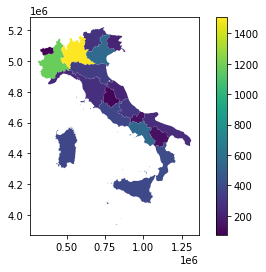

In [ ]:
CIAOO.plot(column="Totale_Comuni", legend=True)

## Lets's practice!

We will again use the Paris datasets to do some exercises. Let's start importing them again:

In [ ]:
districts = geopandas.read_file("data/paris_districts.geojson").to_crs(epsg=2154)
stations = geopandas.read_file("data/paris_bike_stations.geojson").to_crs(epsg=2154)

<div class="alert alert-success">

**EXERCISE:**

* Determine for each bike station in which district it is located (using a spatial join!). Call the result `joined`.

</div>

In [ ]:
# %load _solved/solutions/04-spatial-joins1.py

In [ ]:
# %load _solved/solutions/04-spatial-joins2.py

<div class="alert alert-success">

**EXERCISE: Map of tree density by district (I)**

Using a dataset of all trees in public spaces in Paris, the goal is to make a map of the tree density by district. For this, we first need to find out how many trees each district contains, which we will do in this exercise. In the following exercise, we will then use this result to calculate the density and create a map.

To obtain the tree count by district, we first need to know in which district each tree is located, which we can do with a spatial join. Then, using the result of the spatial join, we will calculate the number of trees located in each district using the pandas 'group-by' functionality.

- Import the trees dataset `"paris_trees.gpkg"` and call the result `trees`. Also read the districts dataset we have seen previously (`"paris_districts.geojson"`), and call this `districts`. Convert the districts dataset to the same CRS as the trees dataset.
- Add a column with the `'district_name'` to the trees dataset using a spatial join. Call the result `joined`.

<details><summary>Hints</summary>

- Remember, we can perform a spatial join with the `geopandas.sjoin()` function.
- `geopandas.sjoin()` takes as first argument the dataframe to which we want to add information, and as second argument the dataframe that contains this additional information.
- The `op` argument is used to specify which spatial relationship between both dataframes we want to use for joining (options are `'intersects'`, `'contains'`, `'within'`).

</details>

</div>

In [ ]:
# %load _solved/solutions/04-spatial-joins3.py

In [ ]:
# %load _solved/solutions/04-spatial-joins4.py

In [ ]:
# %load _solved/solutions/04-spatial-joins5.py

<div class="alert alert-success">

**EXERCISE: Map of tree density by district (II)**

- Calculate the number of trees located in each district: group the `joined` DataFrame by the `'district_name'` column, and calculate the size of each group. We convert the resulting Series `trees_by_district` to a DataFrame for the next exercise.

<details><summary>Hints</summary>

- The general group-by syntax in pandas is: `df.groupby('key').aggregation_method()`, substituting 'key' and 'aggregation_method' with the appropriate column name and method. 
- To know the size of groups, we can use the `.size()` method.


</details>

</div>

In [ ]:
# %load _solved/solutions/04-spatial-joins6.py

In [ ]:
# %load _solved/solutions/04-spatial-joins7.py

In [ ]:
# %load _solved/solutions/04-spatial-joins8.py

<div class="alert alert-success">

**EXERCISE: Map of tree density by district (III)**

Now we have obtained the number of trees by district, we can make the map of the districts colored by the tree density.

For this, we first need to merge the number of trees in each district we calculated in the previous step (`trees_by_district`) back to the districts dataset. We will use the [`pd.merge()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.merge.html) function to join two dataframes based on a common column.

Since not all districts have the same size, it is a fairer comparison to visualize the tree density: the number of trees relative to the area.

- Use the `pd.merge()` function to merge `districts` and `trees_by_district` dataframes on the `'district_name'` column. Call the result `districts_trees`.
- Add a column `'n_trees_per_area'` to the `districts_trees` dataframe, based on the `'n_trees'` column divided by the area.
- Make a plot of the `districts_trees` dataframe, using the `'n_trees_per_area'` column to determine the color of the polygons.


<details><summary>Hints</summary>

- The pandas `pd.merge()` function takes the two dataframes you want to merge as the first two arguments.
- The column name on which you want to merge both datasets can be specified with the `on` keyword.
- Accessing a column of a DataFrame can be done with `df['col']`, while adding a column to a DataFrame can be done with `df['new_col'] = values` where `values` can be the result of a computation.
- Remember, the area of each geometry in a GeoSeries or GeoDataFrame can be retrieved using the `area` attribute. So considering a GeoDataFrame `gdf`, then `gdf.geometry.area` will return a Series with the area of each geometry.
- We can use the `.plot()` method of a GeoDataFrame to make a visualization of the geometries. 
- For using one of the columns of the GeoDataFrame to determine the fill color, use the `column=` keyword.


</details>

</div>

In [ ]:
# %load _solved/solutions/04-spatial-joins9.py

In [ ]:
# %load _solved/solutions/04-spatial-joins10.py

In [ ]:
# %load _solved/solutions/04-spatial-joins11.py

## The overlay operation

In the spatial join operation above, we are not changing the geometries itself. We are not joining geometries, but joining attributes based on a spatial relationship between the geometries. This also means that the geometries need to at least overlap partially.

If you want to create new geometries based on joining (combining) geometries of different dataframes into one new dataframe (eg by taking the intersection of the geometries), you want an **overlay** operation.

In [ ]:
africa = countries[countries['continent'] == 'Africa']

In [ ]:
africa.plot()

In [ ]:
cities['geometry'] = cities.buffer(2)

In [ ]:
geopandas.overlay(africa, cities, how='difference').plot()

<div class="alert alert-info" style="font-size:120%">
<b>REMEMBER</b> <br>

* **Spatial join**: transfer attributes from one dataframe to another based on the spatial relationship
* **Spatial overlay**: construct new geometries based on spatial operation between both dataframes (and combining attributes of both dataframes)

</div>

<div class="alert alert-success">

**EXERCISE: Exploring a Land Use dataset**

For the following exercises, we first introduce a new dataset: a dataset about the land use of Paris (a simplified version based on the open European [Urban Atlas](https://land.copernicus.eu/local/urban-atlas)). The land use indicates for what kind of activity a certain area is used, such as residential area or for recreation. It is a polygon dataset, with a label representing the land use class for different areas in Paris.

In this exercise, we will read the data, explore it visually, and calculate the total area of the different classes of land use in the area of Paris.

* Read in the `'paris_land_use.shp'` file and assign the result to a variable `land_use`.
* Make a plot of `land_use`, using the `'class'` column to color the polygons. We also add a legend. Note: it might take a few seconds for the plot to generate because there are a lot of polygons.
* Add a new column `'area'` with the area of each polygon.
* Calculate the total area in km² for each `'class'` using the `groupby()` method, and print the result.

<details><summary>Hints</summary>

* Reading a file can be done with the `geopandas.read_file()` function.
* To use a column to color the geometries, use the `column` keyword to indicate the column name.
* The area of each geometry can be accessed with the `area` attribute of the `geometry` of the GeoDataFrame.
* The `groupby()` method takes the column name on which you want to group as the first argument.

</details>

</div>

In [ ]:
# %load _solved/solutions/04-spatial-joins12.py

In [ ]:
# %load _solved/solutions/04-spatial-joins13.py

In [ ]:
# %load _solved/solutions/04-spatial-joins14.py

In [ ]:
# %load _solved/solutions/04-spatial-joins15.py

<div class="alert alert-success">

**EXERCISE: Intersection of two polygons**

For this exercise, we are going to use 2 individual polygons: the district of Muette extracted from the `districts` dataset, and the green urban area of Boulogne, a large public park in the west of Paris, extracted from the `land_use` dataset. The two polygons have already been assigned to the `muette` and `park_boulogne` variables.

We first visualize the two polygons. You will see that they overlap, but the park is not fully located in the district of Muette. Let's determine the overlapping part.

* Plot the two polygons in a single map to examine visually the degree of overlap
* Calculate the intersection of the `park_boulogne` and `muette` polygons.
* Print the proportion of the area of the district that is occupied by the park.

<details><summary>Hints</summary>

* The intersection of to scalar polygons can be calculated with the `intersection()` method of one of the polygons, and passing the other polygon as the argument to that method.

</details>

</div>

In [ ]:
land_use = geopandas.read_file("zip://./data/paris_land_use.zip")
districts = geopandas.read_file("data/paris_districts.geojson").to_crs(land_use.crs)

In [ ]:
# extract polygons
land_use['area'] = land_use.geometry.area
park_boulogne = land_use[land_use['class'] == "Green urban areas"].sort_values('area').geometry.iloc[-1]
muette = districts[districts.district_name == 'Muette'].geometry.squeeze()

In [ ]:
# Plot the two polygons
geopandas.GeoSeries([park_boulogne, muette]).plot(alpha=0.5, color=['green', 'blue'])

In [ ]:
# %load _solved/solutions/04-spatial-joins16.py

In [ ]:
# %load _solved/solutions/04-spatial-joins17.py

In [ ]:
# %load _solved/solutions/04-spatial-joins18.py

<div class="alert alert-success">

**EXERCISE: Intersecting a GeoDataFrame with a Polygon**

Combining the land use dataset and the districts dataset, we can now investigate what the land use is in a certain district.

For that, we first need to determine the intersection of the land use dataset with a given district. Let's take again the *Muette* district as example case.

* Calculate the intersection of the `land_use` polygons with the single `muette` polygon. Call the result `land_use_muette`.
* Make a quick plot of this intersection, and pass `edgecolor='black'` to more clearly see the boundaries of the different polygons.
* Print the first five rows of `land_use_muette`.

<details><summary>Hints</summary>

* The intersection of each geometry of a GeoSeries with another single geometry can be performed with the `intersection()` method of a GeoSeries.
* The `intersection()` method takes as argument the geometry for which to calculate the intersection.

</details>

</div>

In [ ]:
land_use = geopandas.read_file("zip://./data/paris_land_use.zip")
districts = geopandas.read_file("data/paris_districts.geojson").to_crs(land_use.crs)
muette = districts[districts.district_name == 'Muette'].geometry.squeeze()

In [ ]:
# %load _solved/solutions/04-spatial-joins19.py

In [ ]:
# %load _solved/solutions/04-spatial-joins20.py

In [ ]:
# Print the first five rows of the intersection
land_use_muette.head()

You can see in the plot that we now only have a subset of the full land use dataset. The `land_use_muette` still has the same number of rows as the original `land_use`, though. But many of the rows, as you could see by printing the first rows, consist now of empty polygons when it did not intersect with the Muette district.

In [ ]:
land_use_muette = land_use.copy()
land_use_muette['geometry'] = land_use.geometry.intersection(muette)
land_use_muette = land_use_muette[~land_use_muette.is_empty]
land_use_muette.head()

In [ ]:
land_use_muette.dissolve(by='class')

In [ ]:
land_use_muette.dissolve(by='class').reset_index().plot(column='class')

<div class="alert alert-success">

**EXERCISE: Overlaying spatial datasets**

We will now combine both datasets in an overlay operation. Create a new `GeoDataFrame` consisting of the intersection of the land use polygons wich each of the districts, but make sure to bring the attribute data from both source layers.

Once we created the overlay of the land use and districts datasets, we can more easily inspect the land use for the different districts. Let's get back to the example district of Muette, and inspect the land use of that district.

* Create a new GeoDataFrame from the intersections of `land_use` and `districts`. Assign the result to a variable `combined`.
* Print the first rows the resulting GeoDataFrame (`combined`).
* Add a new column `'area'` with the area of each polygon to the `combined` GeoDataFrame.
* Create a subset called `land_use_muette` where the `'district_name'` is equal to "Muette".
* Make a plot of `land_use_muette`, using the `'class'` column to color the polygons.
* Calculate the total area for each `'class'` of `land_use_muette` using the `groupby()` method, and print the result.

<details><summary>Hints</summary>

* The intersection of two GeoDataFrames can be calculated with the `geopandas.overlay()` function.
* The `overlay()` functions takes first the two GeoDataFrames to combine, and a third `how` keyword indicating how to combine the two layers.
* For making an overlay based on the intersection, you can pass `how='intersection'`.
* The area of each geometry can be accessed with the `area` attribute of the `geometry` of the GeoDataFrame.
* To use a column to color the geometries, pass its name to the `column` keyword.
* The `groupby()` method takes the column name on which you want to group as the first argument.
* The total area for each class can be calculated by taking the `sum()` of the area.

</details>

</div>

In [ ]:
land_use = geopandas.read_file("zip://./data/paris_land_use.zip")
districts = geopandas.read_file("data/paris_districts.geojson").to_crs(land_use.crs)

In [ ]:
# %load _solved/solutions/04-spatial-joins21.py

In [ ]:
# %load _solved/solutions/04-spatial-joins22.py

In [ ]:
# %load _solved/solutions/04-spatial-joins23.py

In [ ]:
# %load _solved/solutions/04-spatial-joins24.py

In [ ]:
# %load _solved/solutions/04-spatial-joins25.py

In [ ]:
# %load _solved/solutions/04-spatial-joins26.py